**Example code for Autoencoder**

In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create time series dataset of length 10000 
# training dataset
idx=np.arange(0,2000)
train_data=np.sin(2*np.pi*idx/100)+0.2*np.random.randn(2000)
test_data=np.sin(2*np.pi*idx/100)+0.2*np.random.randn(2000)
test_data[1000:1070]=2

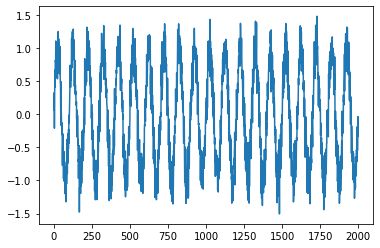

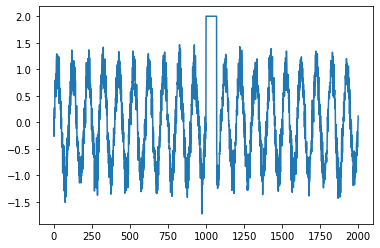

In [3]:
# plot time series data
# train data
plt.figure()
plt.plot(train_data)
# test data
plt.figure()
plt.plot(test_data)

In [4]:
def get_batch(x,window_size=100,interval=1):
  all_batch_x=[]
  for idx in range(0,len(x)-window_size):
    all_batch_x.append(x[idx:idx+window_size:interval])
  return all_batch_x

x_train=get_batch(train_data)
x_test=get_batch(test_data)
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

In [5]:
# Time series Dataset parameters.
num_features = 100 # data features 100

# Training parameters.
learning_rate = 0.01
training_steps = 20000
batch_size = 256
display_step = 1000

# Network Parameters
num_hidden_1 = 128 # 1st layer num features.
num_hidden_2 = 64 # 2nd layer num features (the latent dim).

In [6]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train))
train_data = train_data.repeat().shuffle(1000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [7]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    'encoder_h1': tf.Variable(random_normal([num_features, num_hidden_1])),
    'encoder_h2': tf.Variable(random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(random_normal([num_hidden_1, num_features])),
}
biases = {
    'encoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(random_normal([num_features])),
}

In [8]:
# Building the encoder.
def encoder(x):
    # Encoder Hidden layer with sigmoid activation.
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation.
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder.
def decoder(x):
    # Decoder Hidden layer with sigmoid activation.
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation.
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

In [9]:
# Mean square loss between original images and reconstructed ones.
def mean_square(reconstructed, original):
    return tf.reduce_mean(tf.pow(original - reconstructed, 2))

# Adam optimizer.
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [10]:
# Optimization process. 
def run_optimization(x,options):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        reconstructed_image = decoder(encoder(x))
        loss = mean_square(reconstructed_image, x)

    if options=="train":
      # Variables to update, i.e. trainable variables.
      trainable_variables = list(weights.values()) + list(biases.values())
    
      # Compute gradients.
      gradients = g.gradient(loss, trainable_variables)
    
      # Update W and b following gradients.
      optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss

In [11]:
# Run training for the given number of steps.
for step, batch_x in enumerate(train_data.take(training_steps + 1)):
    
    # Run the optimization.
    loss = run_optimization(batch_x,options="train")
    
    if step % display_step == 0:
        print("step: %i, loss: %f" % (step, loss))

step: 0, loss: 0.790761
step: 1000, loss: 0.541426
step: 2000, loss: 0.459578
step: 3000, loss: 0.288391
step: 4000, loss: 0.289076
step: 5000, loss: 0.291623
step: 6000, loss: 0.288108
step: 7000, loss: 0.280435
step: 8000, loss: 0.283483
step: 9000, loss: 0.287977
step: 10000, loss: 0.281373
step: 11000, loss: 0.278673
step: 12000, loss: 0.285579
step: 13000, loss: 0.283889
step: 14000, loss: 0.282073
step: 15000, loss: 0.274848
step: 16000, loss: 0.284885
step: 17000, loss: 0.282938
step: 18000, loss: 0.282021
step: 19000, loss: 0.274961
step: 20000, loss: 0.282437


In [12]:
anomaly_score=[]
for idx in range(0,len(x_test)):
    # Run the optimization.
    loss = run_optimization(x_test[idx:idx+1],options="test")
    anomaly_score.append(loss)
    if step % display_step == 0:
        print("step: %i, loss: %f" % (idx, loss))

step: 0, loss: 0.337810
step: 1, loss: 0.339386
step: 2, loss: 0.338975
step: 3, loss: 0.324912
step: 4, loss: 0.336538
step: 5, loss: 0.328351
step: 6, loss: 0.336085
step: 7, loss: 0.326347
step: 8, loss: 0.331833
step: 9, loss: 0.335507
step: 10, loss: 0.339958
step: 11, loss: 0.331701
step: 12, loss: 0.333259
step: 13, loss: 0.335023
step: 14, loss: 0.336382
step: 15, loss: 0.358295
step: 16, loss: 0.336981
step: 17, loss: 0.341251
step: 18, loss: 0.338721
step: 19, loss: 0.343417
step: 20, loss: 0.334595
step: 21, loss: 0.336628
step: 22, loss: 0.339148
step: 23, loss: 0.336171
step: 24, loss: 0.329335
step: 25, loss: 0.335566
step: 26, loss: 0.342687
step: 27, loss: 0.339078
step: 28, loss: 0.342371
step: 29, loss: 0.336402
step: 30, loss: 0.335986
step: 31, loss: 0.339763
step: 32, loss: 0.332948
step: 33, loss: 0.340516
step: 34, loss: 0.337829
step: 35, loss: 0.335712
step: 36, loss: 0.332772
step: 37, loss: 0.328680
step: 38, loss: 0.331709
step: 39, loss: 0.338366
step: 40, 

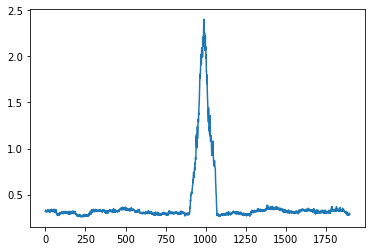

In [ ]:
# Testing and Visualization.
import matplotlib.pyplot as plt
plt.figure()
plt.plot(anomaly_score)